In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体，或者使用你系统上可用的其他字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [2]:
#利用AskPrice1和BidPrice1计算价格的平均值，进而计算分钟频的收益率
def mid_price(df):
    mid = (df['AskPrice1'] + df['BidPrice1'])/2
    mid = mid.astype(float)
    return mid

In [3]:
def calculate_ic(factors, returns):
    """
    计算单因子或多因子模型的IC。
    :param factors: 预测因子,可以是单因子,也可以是多因子拟合后得到的y-pred。
    :param returns: 实际的未来回报,Series 格式。
    :return: 信息系数(IC)
    """
    # 计算皮尔逊相关系数
    ic, _ = pearsonr(factors, returns)
    return ic

In [4]:
#由于日盘无法获取前一期夜盘数据，夜盘也无法获取前一期日盘的数据
def process_day(group, prev_period, back_period):
    split_time = pd.to_datetime(group['trading_date'].iloc[0].strftime('%Y-%m-%d') + ' 08:00:00')
    before_8 = group[group['exchange_time'] < split_time].iloc[prev_period:-back_period]
    after_8 = group[group['exchange_time'] >= split_time].iloc[prev_period:-back_period]
    return pd.concat([before_8, after_8])

In [5]:
table = pd.read_parquet('ag')


table['trading_date'] = pd.to_datetime(table['trading_date']) 

# 设置开始和结束时间
start_time_0 = pd.to_datetime('2023-07-01')
end_time_0 = pd.to_datetime('2024-06-30')

# 提取时间范围内的数据
table = table[(table['trading_date'] >= start_time_0) & (table['trading_date'] <= end_time_0)]

# 当 AskPrice1 为 0 时，用 BidPrice1 替换
table['AskPrice1'] = table['AskPrice1'].where(table['AskPrice1'] != 0, table['BidPrice1'])

# 当 BidPrice1 为 0 时，用 AskPrice1 替换
table['BidPrice1'] = table['BidPrice1'].where(table['BidPrice1'] != 0, table['AskPrice1'])

In [6]:
table['current_volume'] = table['Volume'].diff()
table['Position Increase'] = table['OpenInterest'].diff()
table['current_turnover'] = table['Turnover'].diff()
table['current_avg_price'] = table['current_turnover']/(table['current_volume']*15)
table['mid_price'] = mid_price(table)

In [7]:
#判断是否主动买卖
table['主动买or主动卖'] = '被动买卖'
table.loc[table['last'] >= table['AskPrice1'].shift(1),'主动买or主动卖'] = '主动买'
table.loc[table['last'] <= table['BidPrice1'].shift(1),'主动买or主动卖'] = '主动卖'

In [8]:
#构造基础信息：成交价格对，以及以高价成交和低价成交的比例
table['前一期成交价格对'] = 'BidPrice1 and AskPrice1'
table['前一期Low Price比例'] = (table['current_avg_price'] - table['AskPrice1'].shift(1))/(table['BidPrice1'].shift(1) - table['AskPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice1 and AskPrice2'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice2 and BidPrice1'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice2'].shift(1))/(table['AskPrice1'].shift(1) - table['AskPrice2'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice1'].shift(1))/(table['BidPrice2'].shift(1) - table['BidPrice1'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice2 and AskPrice3'
table.loc[(table['前一期Low Price比例'] > 1),'前一期成交价格对'] = 'BidPrice3 and BidPrice2'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice3'].shift(1))/(table['AskPrice2'].shift(1) - table['AskPrice3'].shift(1))
table['前一期Low Price比例'].loc[(table['前一期Low Price比例'] > 1)] = (table['current_avg_price'] - table['BidPrice2'].shift(1))/(table['BidPrice3'].shift(1) - table['BidPrice2'].shift(1))
table['前一期High Price比例'] = 1 - table['前一期Low Price比例']
table.loc[(table['前一期High Price比例'] > 1),'前一期成交价格对'] = 'AskPrice3 and AskPrice4'
table['前一期Low Price比例'].loc[(table['前一期High Price比例'] > 1)] = (table['current_avg_price'] - table['AskPrice4'].shift(1))/(table['AskPrice3'].shift(1) - table['AskPrice4'].shift(1))
table['前一期High Price比例'] = 1-table['前一期Low Price比例']

In [9]:
#计算收益，即y值
table['return'] = -mid_price(table).diff(-120)

In [10]:
#处理缺失值
table['前一期Low Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)
table['前一期High Price比例'].replace([np.inf, -np.inf], np.nan, inplace=True)

table['current_volume'].fillna(0, inplace=True)
table['Position Increase'].fillna(0, inplace=True)
table['current_turnover'].fillna(0, inplace=True)
table['current_avg_price'].fillna(method='ffill',inplace=True)

#table['Low Price比例'].fillna(0, inplace=True)
#table['High Price比例'].fillna(0, inplace=True)
table['前一期Low Price比例'].fillna(0, inplace=True)
table['前一期High Price比例'].fillna(0, inplace=True)
table['return'].fillna(0, inplace=True)

In [11]:
#因子：前一期不同成交价格比例之差
#同时我们对成交价格对不为“AskPrice1 and BidPrice1”的数据进行惩罚。
#如果全都以买价成交，说明有下降趋势，我们给他一个负的惩罚项；如果全都以卖价成交，说明有上升趋势，我们给一个正的惩罚项。

table['Difference in Trading Pct'] = table['前一期High Price比例'] - table['前一期Low Price比例']
table['New_Difference in Trading Pct'] = 0
table['New_Difference in Trading Pct'].loc[table['前一期成交价格对'] == 'BidPrice1 and AskPrice1'] = table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 0.5 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 0.8 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'AskPrice3 and AskPrice4')] = 2.7 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -0.5 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -0.8 + table['Difference in Trading Pct']
table['New_Difference in Trading Pct'].loc[(table['前一期成交价格对'] == 'BidPrice4 and BidPrice3')] = -2.7 + table['Difference in Trading Pct']
table['factor'] = table['New_Difference in Trading Pct']

In [326]:
#因子：主动买卖信号
table['factor1_weight'] = 0
table['factor1_weight'].loc[table['主动买or主动卖']=='主动买'] = 0.2
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice1 and AskPrice2')] = 1.2
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'AskPrice2 and AskPrice3')] = 1.8
table['factor1_weight'].loc[table['主动买or主动卖']=='主动卖'] = -0.2
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice2 and BidPrice1')] = -1.2
table['factor1_weight'].loc[(table['前一期成交价格对'] == 'BidPrice3 and BidPrice2')] = -1.8
table['factor1'] = table['factor1_weight']*table['current_volume']

In [327]:
#想法是用短期std()相对于长期std()来反映比较大的波动，但是std()无法反映变动方向，于是考虑加入主动买卖信号来判断方向
#用“-1、0、1”做解释变量还是用其他指标
#首先尝试，std（）的相对强弱* factor1
table['std_20_tick'] = table['current_volume'].rolling(20).std()
table['std_125_tick'] = table['current_volume'].rolling(125).std()
table['factor2'] = (table['std_20_tick']/table['std_125_tick']) * table['factor1_weight']


In [328]:
table['factor3'] = table['current_avg_price'] - table['mid_price']
table['factor3'] = table['factor3']-table['factor3'].rolling(110).mean()

In [329]:
cols_to_standardize = ['factor','factor1','factor2','factor3']
table[cols_to_standardize] = table[cols_to_standardize].apply(lambda x: (x - x.mean()) / x.std())

In [330]:
# table['transform_factor2'] = np.log(abs(3/(table['factor2']+1.5)-1))/(-25)
# table['factor2'] = table['transform_factor2'] * (np.abs(table['transform_factor2']) <= 1.5) + table['factor2']*(np.abs(table['transform_factor2']>1.5))

In [331]:
table['factor'].fillna(0,inplace=True)
table['factor1'].fillna(0,inplace=True)
table['factor2'].fillna(0,inplace=True)
table['factor3'].fillna(0,inplace=True)

In [332]:
table['factor4'] = (table['AskVolume1']-table['BidVolume1'])/(table['AskVolume1']+table['BidVolume1'])

In [333]:
table['trading_date'] = pd.to_datetime(table['trading_date'])
# 删除 'trading_date' 为 '2024-04-08' 和 '2024-05-20' 的行
new_table = table[~table['trading_date'].isin([pd.to_datetime('2024-04-08'), pd.to_datetime('2024-05-20')])]
new_table = table.groupby('trading_date').apply(process_day, prev_period=120, back_period=120)

In [342]:
# # 创建示例 DataFrame
# np.random.seed(42)  # 固定随机种子，确保结果一致
# data = {
#     'Factor1': np.random.randn(1000),  # 1000 个随机因子值
#     'return': np.random.randn(1000)  # 1000 个随机收益值
# }
# df = pd.DataFrame(data)

# 根据 Factor1 排序
new_table_sorted = new_table.sort_values(by='factor4', ascending=True)

# 将排序后的数据分为 100 组
new_table_sorted['group'] = pd.qcut(new_table['factor4'], 500, labels=False,duplicates='drop')

# 计算每组内 Factor1 和 return 的均值
grouped = new_table_sorted.groupby('group').agg(
    factor4_mean=('factor4', 'mean'),
    return_mean=('return', 'mean')
).reset_index()




In [340]:
# grouped = grouped[(grouped['return_mean']<0.25) & (grouped['return_mean']>-0.25)]
grouped

,group,factor3_mean,return_mean
0,0,-2.859295,-0.432213
1,1,-2.211696,-0.326572
2,2,-1.896846,-0.270420
3,3,-1.711413,-0.223408
4,4,-1.582769,-0.206584
...,...,...,...
495,495,1.579059,0.216785
496,496,1.704408,0.160237
497,497,1.885950,0.139088
498,498,2.194615,0.366665


In [336]:
# # 三次多项式拟合
# x = grouped['factor1_mean']
# y = grouped['return_mean']
# coefficients = np.polyfit(x, y, 3)  # 3 表示三次多项式
# polynomial = np.poly1d(coefficients)

# # 生成拟合曲线
# x_fit = np.linspace(min(x), max(x), 200)
# y_fit = polynomial(x_fit)
# print("Polynomial coefficients:", coefficients)

# # 可视化数据点和拟合曲线
# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, color='blue', label='Data Points')  # 数据点
# plt.plot(x_fit, y_fit, color='red', label='Cubic Fit')  # 拟合曲线
# plt.title('Cubic Polynomial Fit')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()
# plt.grid(True)
# plt.show()

<Axes: title={'center': 'Factor4 vs Return'}, xlabel='factor4_mean', ylabel='return_mean'>

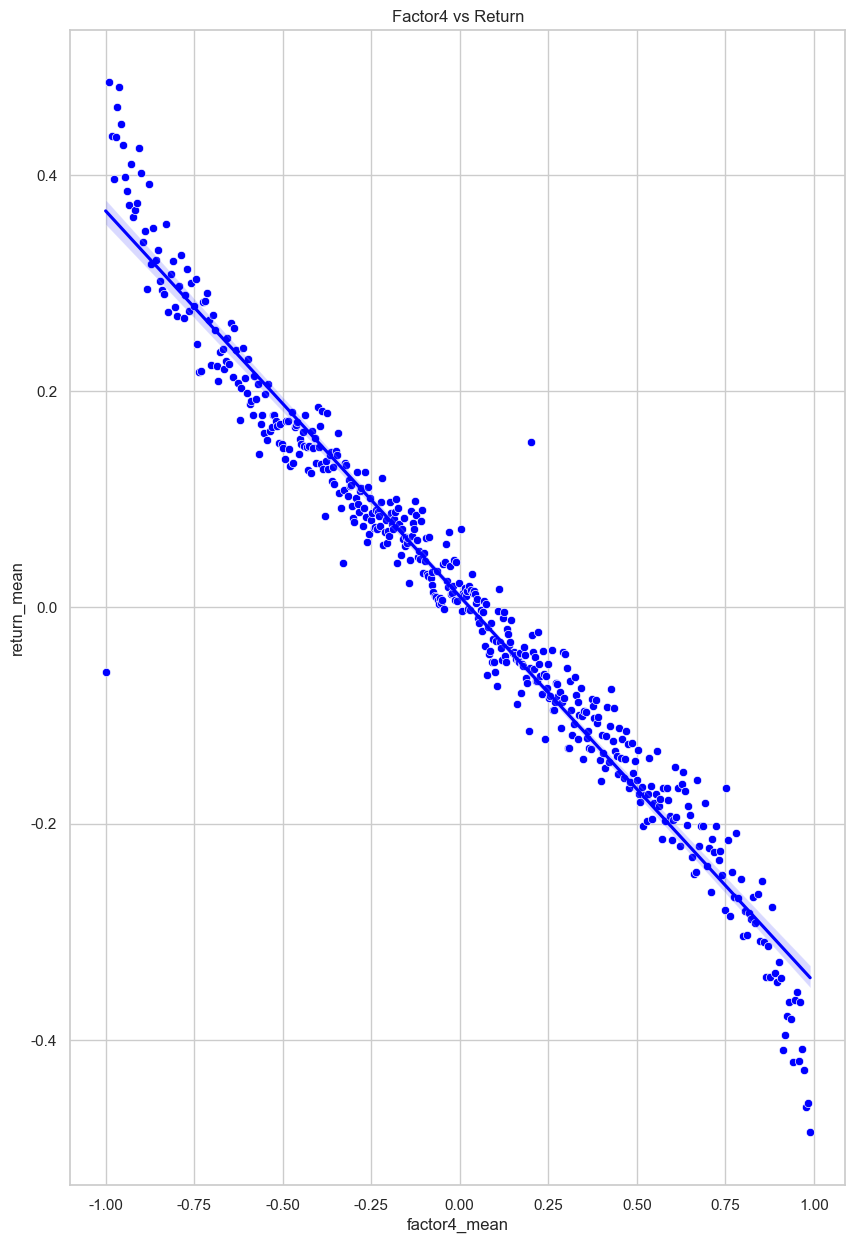

In [343]:
sns.set(style="whitegrid")
# 创建一个画布和子图（3行1列的图，方便展示每个因子与return的关系）
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
sns.scatterplot(data=grouped, x='factor4_mean', y='return_mean', ax=ax, color='blue')
ax.set_title('Factor4 vs Return')
# 添加回归线
sns.regplot(x='factor4_mean', y='return_mean', data=grouped, ax=ax, scatter=False, color='blue')
